# Analysis

## Build corpus

In [4]:
from xml.etree import ElementTree as ET

wiki_fname = 'kowiki-latest-pages-articles.xml'

In [5]:
import re

def clean_text(text):    
    # Common
    text = re.sub("(?s)<ref>.+?</ref>", "", text) # remove reference links
    text = re.sub("(?s)<[^>]+>", "", text) # remove html tags
    text = re.sub("&[a-z]+;", "", text) # remove html entities
    text = re.sub("(?s){{.+?}}", "", text) # remove markup tags
    text = re.sub("(?s){.+?}", "", text) # remove markup tags
    text = re.sub("(?s)\[\[([^]]+\|)", "", text) # remove link target strings
    text = re.sub("(?s)\[\[([^]]+\:.+?]])", "", text) # remove media links
    
    text = re.sub("[']{5}", "", text) # remove italic+bold symbols
    text = re.sub("[']{3}", "", text) # remove bold symbols
    text = re.sub("[']{2}", "", text) # remove italic symbols
    
    text = re.sub(u"[^\s\r\n가-힣.?!]", " ", text) # Replace unacceptable characters with a space.
    text = re.sub('([.?!]){2,}', '\\1', text) # remove repeated punctuation
    text = re.sub('\s[.?!]\s', '', text) # remove isolated punctuation
    
    # Common
    text = re.sub("\s{2,}", " ", text) # Squeeze spaces.
    return text

In [10]:
def sentence_segment(text):
    '''
    Args:
      text: A string. A unsegmented paragraph.
    
    Returns:
      A list of sentences.
    '''
    return re.split('([.?!])?[\n]+|[.?!] ', text)

In [11]:
from konlpy.tag import Mecab

mecab = Mecab()
def word_segment(text):
    return [word for word, _ in mecab.pos(text)]

In [49]:
from tqdm import tqdm

ns = '{http://www.mediawiki.org/xml/export-0.10/}'
with open(f'./data/{wiki_fname.split("-")[0]}_corpus.txt', 'w', encoding='utf-8') as fout:
    for _, elem in tqdm(ET.iterparse(f'./data/{wiki_fname}')):
        try:
            tag = elem.tag.replace(ns, '')
            if tag == 'text':
                running_text = clean_text(elem.text)
                sents = sentence_segment(running_text)
                for sent in sents:
                    if sent:
                        words = word_segment(sent)
                        if len(words) > 10:
                            fout.write(' '.join(words) + '\n')
        except:
            continue
        elem.clear()

25979812it [30:56, 13991.10it/s]


## Make wor2vec

In [4]:
from gensim.models import Word2Vec

min_count = 5
window_size = 5
num_neg = 15
vector_size = 300

print('Making sentences as list...')
sents = []
corpus_fname = 'kowiki_corpus.txt'

with open(f'./data/{corpus_fname}', 'r', encoding='utf8') as fin:
    line = fin.readline()
    while line:
        words = line.split()
        sents.append(words)
        line = fin.readline()

print('Making word vectors...')
w2v_model = Word2Vec(sents, vector_size=vector_size, min_count=min_count, negative=num_neg, window=window_size)

w2v_model.save('./models/kowiki-neg-300.bin')

Making sentences as list...
Making word vectors...


In [13]:
w2v_model.wv.most_similar('독감')

[('인플루엔자', 0.7366062998771667),
 ('홍역', 0.6661979556083679),
 ('콜레라', 0.652269721031189),
 ('출혈열', 0.648910641670227),
 ('유행병', 0.6479013562202454),
 ('전염병', 0.6393334269523621),
 ('뎅기열', 0.6355220079421997),
 ('대유행', 0.6307356357574463),
 ('말라리아', 0.6306702494621277),
 ('광견병', 0.6233310103416443)]

In [14]:
w2v_kv = w2v_model.wv
w2v_kv.save('./models/kowiki-neg-300.kv')

## Extract "flu-related" words

In [1]:
from gensim.models import KeyedVectors

kv_fname = 'kowiki-neg-300.kv'
w2v_kv = KeyedVectors.load(f'./models/{kv_fname}')

In [3]:
w2v_kv.most_similar_cosmul(positive=['독감', '증상'], topn=10)

[('질병', 0.6456781029701233),
 ('합병증', 0.6416015028953552),
 ('패혈증', 0.6396576166152954),
 ('피부병', 0.6389033198356628),
 ('황달', 0.637260377407074),
 ('매독', 0.6342878341674805),
 ('기관지염', 0.6325851678848267),
 ('폐렴', 0.6323192715644836),
 ('급성', 0.6281660795211792),
 ('복통', 0.6278930902481079)]

In [21]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [4]:
from pytrends.request import TrendReq

flu_related_words = ['독감'] + [w for w, _ in w2v_kv.most_similar_cosmul(positive=['독감', '증상'], topn=1000)]
pyt = TrendReq(hl='ko-KR')

In [25]:
import pandas as pd
import time
from tqdm import tqdm

for i, keywords in tqdm(enumerate(chunks(flu_related_words, 5))):
    try:
        pyt.build_payload(keywords, timeframe='2017-01-01 2021-06-05', geo='KR')
        trends = pd.concat([trends, pyt.interest_over_time()], axis=1)
        trends.pop('isPartial')
        trends.to_csv('./data/독감+증상_google_trends.csv')
        time.sleep(5)
    except:
        print(i, keywords)
        break


199it [21:14,  6.40s/it]


In [31]:
trends

,독감,질병,합병증,패혈증,피부병,황달,매독,기관지염,폐렴,급성,...,성욕,뇌막,뇌일혈,에리트로포이에틴,원추각막,열대병,요법,마비저,손상,통풍
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,16,6,1,0,2,0,0,0,1,0,...,68,0,0,0,0,0,63,0,63,52
2017-01-08,10,6,1,1,1,0,0,0,1,0,...,55,0,0,0,4,0,52,0,37,61
2017-01-15,9,5,1,0,1,1,0,0,1,1,...,42,0,0,0,0,0,40,0,44,41
2017-01-22,3,4,1,1,2,0,0,0,1,1,...,40,0,0,0,0,0,31,0,35,29
2017-01-29,2,5,2,1,1,0,0,0,1,2,...,65,0,0,0,0,0,46,0,21,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-02,3,22,1,2,1,0,0,0,1,1,...,33,0,0,0,4,0,31,0,47,37
2021-05-09,3,33,2,1,0,0,0,0,1,1,...,39,0,0,0,0,0,40,0,34,35
2021-05-16,3,17,2,1,0,0,0,0,1,1,...,40,0,0,0,0,0,37,0,61,35


## Correlation between flu and google trends 

In [1]:
from tqdm import tqdm
import pandas as pd

flu_trends = pd.read_csv('./data/flu_trends.csv')

In [2]:
# flu_trends = pd.merge(flu_rate, word_trends)
# flu_trends.to_csv('./data/flu_trends.csv', index=False)

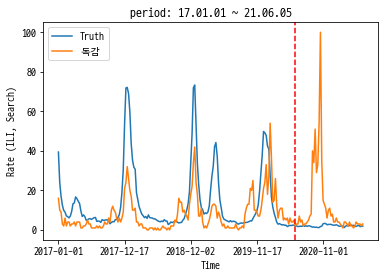

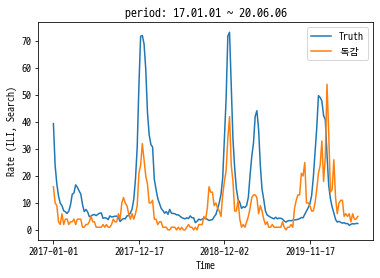

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'D2Coding'

# 17.01.01 ~ 21.06.05
plt.plot(flu_trends['ILI'], label='Truth')
plt.plot(flu_trends['독감'], label='독감')
plt.axvline(len(flu_trends)-52, c='red', ls='--')
plt.xticks(range(0, 201, 50), [flu_trends['date'][i] for i in range(0, 201, 50)])
plt.title('period: 17.01.01 ~ 21.06.05')
plt.xlabel('Time')
plt.ylabel('Rate (ILI, Search)')
plt.legend()
plt.show()

# 17.01.01 ~ 20.06.06
plt.plot(flu_trends['ILI'][:-52], label='Truth')
plt.plot(flu_trends['독감'][:-52], label='독감')
plt.xticks(range(0, 151, 50), [flu_trends['date'][i] for i in range(0, 151, 50)])
plt.title('period: 17.01.01 ~ 20.06.06')
plt.xlabel('Time')
plt.ylabel('Rate (ILI, Search)')
plt.legend()
plt.show()

In [3]:
flu_trends_rm1y = flu_trends[:-52]

In [4]:
def cross_corr(x, y, max_lag=0):
    '''
    Args:
        x (pandas.Series): fixed data
        y (pandas.Series): data to be shifted
    
    Returns:
        corr (pandas.Series): {0: XX.XX, 1: XX.XX, ..., max_lag: XX.XX}
    '''
    corr = {}
    for lag in range(max_lag+1):
        corr[lag] = x.corr(y.shift(lag))
    return pd.Series(corr)


In [5]:
word_trends_with_lag = {word: cross_corr(flu_trends_rm1y['ILI'], flu_trends_rm1y[word], max_lag=12)
                         for word in tqdm(flu_trends_rm1y.columns[2:])}

100%|██████████| 1001/1001 [00:06<00:00, 159.83it/s]


In [6]:
import numpy as np

corr_topn = [(word, corr[0]) for word, corr in word_trends_with_lag.items() if not np.isnan(corr[0])]
corr_topn.sort(key=(lambda x: x[1]), reverse=True)

In [7]:
corr_topn[:10]

[('독감', 0.6979971655966585),
 ('감기', 0.6057191438596866),
 ('몸살', 0.5889798823270904),
 ('기침', 0.3876285746258827),
 ('췌장', 0.3608778113287914),
 ('고열', 0.30212302788295675),
 ('탄저균', 0.29857257200851156),
 ('보균자', 0.29653042044449096),
 ('환각', 0.2515249085001921),
 ('용종', 0.2282457533134259)]

In [8]:
corr_topn_lag = []
for word, corr in word_trends_with_lag.items():
    try:
        lag = corr.argmax()
        max_corr = corr[lag]
        corr_topn_lag.append((word, max_corr, lag))
    except:
        continue # if all elements are NaN, continue

corr_topn_lag.sort(key=(lambda x: x[1]), reverse=True)

In [9]:
corr_topn_lag[:10]

[('독감', 0.6979971655966585, 0),
 ('감기', 0.6057191438596866, 0),
 ('몸살', 0.5889798823270904, 0),
 ('저체온증', 0.5415003240053498, 6),
 ('접종', 0.48151825584155167, 11),
 ('창궐', 0.41881283249748075, 4),
 ('흉부', 0.40158419376844445, 10),
 ('비염', 0.3977656109111145, 12),
 ('췌장', 0.3881219654022702, 7),
 ('기침', 0.3876285746258827, 0)]

## Preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler

flu_scaler = MinMaxScaler()
flu_scaler.fit(flu_trends_rm1y[['ILI']].values)
flu_trends_rm1y_norm = pd.DataFrame(MinMaxScaler().fit_transform(flu_trends_rm1y.values[:, 1:]),
                                    columns=flu_trends_rm1y.columns[1:])
flu_trends_rm1y_norm.insert(0, 'date', flu_trends_rm1y['date'].values)

In [11]:
import tensorflow as tf
import numpy as np

In [12]:
class DataGenerator():
    def __init__(self, raw_data, input_width, label_width,
                 feature_cols, label_cols, shift=1, stride=1,
                 train_split=0.8, val_split=0.1, test_split=0.1):
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.stride = stride
        self.feature_cols = feature_cols
        self.label_cols = label_cols
        self.raw_data = raw_data
        self.window_size = input_width+label_width
        self.data_size = len(raw_data)-self.window_size+1
        self.train_size = int(train_split*self.data_size)
        self.val_size = int(val_split*self.data_size)
        self.test_size = self.data_size-self.train_size-self.val_size
        self.train_pos = self.train_size
        self.val_pos = self.train_pos+self.val_size
        self.test_pos = self.val_pos+self.test_size
        
        self.make_dataset()

    def __repr__(self):
        return '\n'.join([f'total window: {[_*self.stride for _ in range(self.window_size)]}',
                          f'input width: {[_*self.stride for _ in range(self.input_width)]}',
                          f'label width: {[_*self.stride for _ in range(self.input_width, self.window_size)]}'])

    def make_dataset(self):
        def sub_to_branch(sub):
            return sub.batch(self.window_size, drop_remainder=True)
        
        def slice_feature_label(feature_batch, label_batch):
            return ((feature_batch[:self.input_width], label_batch[-self.label_width-1:-1]),
                         label_batch[-self.label_width:])

        feature_ds = tf.data.Dataset.from_tensor_slices(self.raw_data[self.feature_cols].values)
        feature_ds = feature_ds.window(self.window_size, shift=self.shift, stride=self.stride).flat_map(sub_to_branch)
        label_ds = tf.data.Dataset.from_tensor_slices(self.raw_data[self.label_cols].values)
        label_ds = label_ds.window(self.window_size, shift=self.shift, stride=self.stride).flat_map(sub_to_branch)

        dataset = tf.data.Dataset.zip((feature_ds, label_ds)).map(slice_feature_label)
        self.dataset = dataset
        self.train = dataset.take(self.train_size)
        self.val = dataset.skip(self.train_size).take(self.val_size)
        self.test = dataset.skip(self.train_size).skip(self.val_size)

In [473]:
sample_dg = DataGenerator(flu_trends_rm1y_norm, 12, 8, ['ILI'], 'ILI',
             train_split=0.6, val_split=0.1, test_split=0.3)
for batch, (features, label) in enumerate(sample_dg.dataset.batch(32).take(1)):
    print(batch, features[0].shape, features[1].shape, label.shape)

0 (32, 12, 1) (32, 8) (32, 8)


## Model training

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Encoder, self).__init__()
        self.units = units
        self.gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)

    def call(self, inputs, training=None):
        output, state = self.gru(inputs)
        return output, state

In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, units, is_attn=True):
        super(Decoder, self).__init__()
        self.units = units
        self.is_attn = is_attn
        self.gru_cell = tf.keras.layers.GRUCell(units)
        self.gru = tf.keras.layers.RNN(self.gru_cell, return_sequences=True, return_state=True)
        if is_attn:
            self.attention = tf.keras.layers.Attention()
        self.dense = tf.keras.layers.Dense(1, activation='relu')

    def call(self, inputs, hidden, enc_output, training=None):
        attention_weights = None
        if self.is_attn:
            context_vector, attention_weights = self.attention([tf.expand_dims(hidden, 1), enc_output],
                                                                return_attention_scores=True)
            inputs = tf.concat([tf.expand_dims(inputs, 1), context_vector], axis=-1)
        else:
            inputs = tf.expand_dims(inputs, 1)
        output, state = self.gru(inputs, initial_state=[hidden])
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.dense(output)
        return output, state, attention_weights

In [15]:
from tqdm import tqdm

class Seq2Seq():
    def __init__(self, units, data_gen, is_attn=False,):
        self.units = units
        self.data_gen = data_gen
        self.is_attn = is_attn

        self.encoder = Encoder(units)
        self.decoder = Decoder(units, is_attn=is_attn)
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_func = tf.keras.losses.MeanSquaredError()

        self.checkpoint = tf.train.Checkpoint(optimizer=self.optimizer, 
                                                  encoder=self.encoder,
                                                  decoder=self.decoder)
    
    @tf.function
    def train_step(self, inp, targ):
        loss = 0
        with tf.GradientTape() as tape:
            enc_out, enc_state = self.encoder(inp[0], training=True) 
            dec_state = enc_state

            for t in range(targ.shape[1]):
                dec_inp = tf.expand_dims(inp[1][:, t], 1)
                prd, dec_state, _ = self.decoder(dec_inp, dec_state, enc_out, training=True)
                loss += self.loss_func(targ[:, t], prd[:, 0])
            
            batch_loss = loss/targ.shape[1]
            variables = self.encoder.trainable_variables+self.decoder.trainable_variables
            gradients = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    def test_step(self, inp, targ):
        loss = 0
        enc_out, enc_state = self.encoder(inp[0]) 
        dec_state = enc_state
        dec_inp = tf.expand_dims(inp[1][:, 0], 1)

        batch_predictions = None
        for t in range(targ.shape[1]):
            prd, dec_state, attn_weights = self.decoder(dec_inp, dec_state, enc_out)
            loss += self.loss_func(targ[:, t], prd[:, 0])
            dec_inp = prd
            if batch_predictions is None:
                batch_predictions = prd
            else:
                batch_predictions = tf.concat([batch_predictions, prd], axis=1)            
        
        batch_loss = loss/targ.shape[1]
        return batch_predictions, batch_loss, attn_weights

    def train_model(self, epochs=1, batch_size=32, patience=None, save_dir=None, plot_history=False):
        if save_dir:
            checkpoint_manager = tf.train.CheckpointManager(
                self.checkpoint, max_to_keep=3, directory=save_dir)

        history = {'loss': [], 'val_loss': []}

        best_val_loss = float('inf')
        prev_val_loss = float('inf')
        patience_counter = 0
        for epoch in tqdm(range(epochs)):
            train_loss = 0
            val_loss = 0

            for batch, (inp, targ) in enumerate(self.data_gen.train.batch(batch_size)):
                batch_loss = self.train_step(inp, targ)
                train_loss += batch_loss
            if batch != 0:
                train_loss /= batch

            for batch, (inp, targ) in enumerate(self.data_gen.val.batch(batch_size)):
                prds, batch_loss, _ = self.test_step(inp, targ)
                val_loss += batch_loss
            if batch != 0:
                val_loss /= batch
            
            if save_dir and val_loss < best_val_loss:
                best_val_loss = val_loss
                checkpoint_manager.save()
            if val_loss > prev_val_loss:
                patience_counter += 1
            else:
                patience_counter = 0
            if patience and patience_counter > patience:
                print('early stop training...')
                break

            prev_val_loss = val_loss
            history['loss'].append(train_loss.numpy())
            history['val_loss'].append(val_loss.numpy())
            # print(f'Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

        if plot_history:
            plt.plot(history['loss'], label='loss')
            plt.plot(history['val_loss'], label='val_loss')
            plt.legend()
            plt.show()

        return history

    def restore(self, dir_path):
        self.checkpoint.restore(tf.train.latest_checkpoint(dir_path)).expect_partial()
        print('load model...')

    def predict(self, dataset=None, data_range='total'):
        if dataset is None:
            if data_range=='train':
                dataset = self.data_gen.train
            elif data_range=='val':
                dataset = self.data_gen.val
            elif data_range=='test':
                dataset = self.data_gen.test
            else:
                dataset = self.data_gen.dataset
        
        data_size = len(list(dataset))
        for inp, targ in dataset.batch(data_size):
            prds, _, attn_weights = self.test_step(inp, targ)
        return tf.squeeze(prds).numpy(), attn_weights

    def evaluate(self, methods, data_range='test'):
        if data_range=='train':
            pos_slice = slice(0, self.data_gen.train_pos)
        elif data_range=='val':
            pos_slice = slice(self.data_gen.train_pos, self.data_gen.val_pos)
        elif data_range=='test':
            pos_slice = slice(self.data_gen.val_pos, self.data_gen.test_pos)
        else:
            pos_slice = slice(0, self.data_gen.data_size)

        eval = []
        for step in range(self.data_gen.label_width):
            target_slice = slice(self.data_gen.input_width+step,
                                 len(self.data_gen.raw_data)-self.data_gen.label_width+step+1)
            x = data_gen.raw_data['ILI'].values[target_slice][pos_slice]
            y = self.predict(data_range=data_range)[0][:, step]
            eval.append([method(x, y) for method in methods])
        return np.array(eval)

    def plot_by_step(self, step):
        total_slice = slice(self.data_gen.input_width+step,
                            len(self.data_gen.raw_data)-self.data_gen.label_width+1+step)
        plt.plot(self.data_gen.raw_data['ILI'].values[total_slice], c='k', label='ILI')
        plt.plot(self.predict(data_range='train')[0][:, step], label='train')
        plt.plot(range(self.data_gen.train_pos, self.data_gen.val_pos), self.predict(data_range='val')[0][:, step], label='val')
        plt.plot(range(self.data_gen.val_pos, self.data_gen.test_pos), self.predict(data_range='test')[0][:, step], label='test')
        plt.axvline(self.data_gen.train_pos, c='k', ls='--')
        plt.axvline(self.data_gen.val_pos, c='k', ls='--')
        plt.xticks(range(0, self.data_gen.test_pos, 50), [self.data_gen.raw_data['date'].values[total_slice][i] for i in range(0, self.data_gen.test_pos, 50)])
        plt.xlabel('Time')
        plt.ylabel('ILI')
        plt.legend()
        plt.show()

    def plot_all(self, data_range='total'):
        if data_range=='train':
            dataset = self.data_gen.train
            target_range = range(self.data_gen.train_size)
            target_slice = slice(0, self.data_gen.train_pos+self.data_gen.label_width)
        elif data_range=='val':
            dataset = self.data_gen.val
            target_range = range(self.data_gen.val_size)
            target_slice = slice(self.data_gen.train_pos, self.data_gen.val_pos+self.data_gen.label_width)
        elif data_range=='test':
            dataset = self.data_gen.test
            target_range = range(self.data_gen.test_size)
            target_slice = slice(self.data_gen.val_pos, self.data_gen.test_pos+self.data_gen.label_width)
        else:
            dataset = self.data_gen.dataset
            target_range = range(self.data_gen.data_size)
            target_slice = slice(0, self.data_gen.data_size+self.data_gen.label_width)
        total_slice = slice(self.data_gen.input_width, len(self.data_gen.raw_data))

        plt.plot(self.data_gen.raw_data['ILI'].values[total_slice][target_slice], c='k')        
        for batch, (inp, targ) in enumerate(dataset.batch(1)):
            prds, _, _ = self.test_step(inp, targ)
            plt.plot(range(batch, batch+self.data_gen.label_width), tf.squeeze(prds))
        plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

RMSE = lambda x, y: mean_squared_error(x, y)**0.5
MAE = mean_absolute_error
CORR = lambda x, y: pd.Series(x).corr(pd.Series(y))

In [24]:
data_gen = DataGenerator(raw_data=flu_trends_rm1y_norm,
                         input_width=12, label_width=9,
                         feature_cols=['ILI'] + [in corr_topn[:1]], label_cols='ILI',
                         train_split=0.5, val_split=0.2, test_split=0.3)



In [22]:
corr_topn_lag[:10]

[('독감', 0.6979971655966585, 0),
 ('감기', 0.6057191438596866, 0),
 ('몸살', 0.5889798823270904, 0),
 ('저체온증', 0.5415003240053498, 6),
 ('접종', 0.48151825584155167, 11),
 ('창궐', 0.41881283249748075, 4),
 ('흉부', 0.40158419376844445, 10),
 ('비염', 0.3977656109111145, 12),
 ('췌장', 0.3881219654022702, 7),
 ('기침', 0.3876285746258827, 0)]

100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


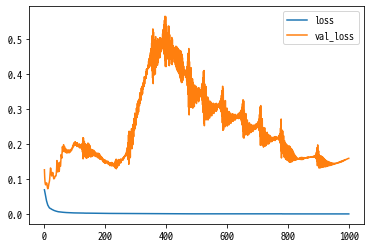

load model...
Top N: 2
 68%|██████▊   | 685/1000 [02:42<01:14,  4.22it/s]
early stop training...


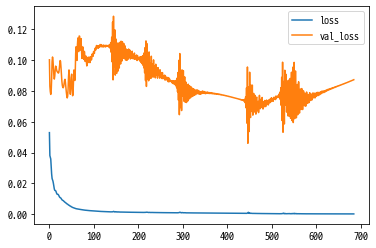

load model...
Top N: 3
100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


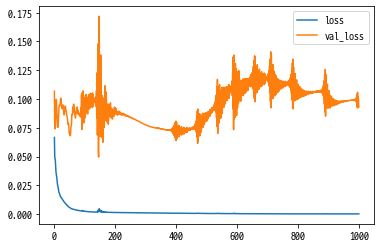

load model...
100%|██████████| 1000/1000 [02:55<00:00,  5.68it/s]


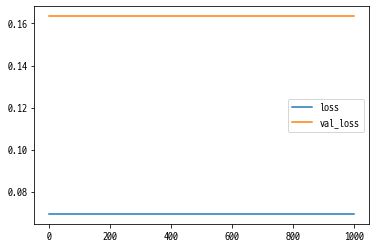

load model...
 11%|█         | 107/1000 [00:30<04:14,  3.51it/s]
early stop training...


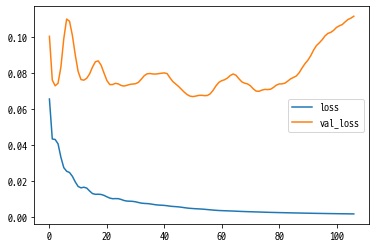

load model...
 22%|██▏       | 222/1000 [00:50<02:57,  4.38it/s]
early stop training...


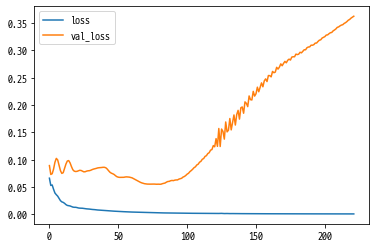

load model...
Top N: 7
 13%|█▎        | 133/1000 [00:33<03:41,  3.91it/s]early stop training...



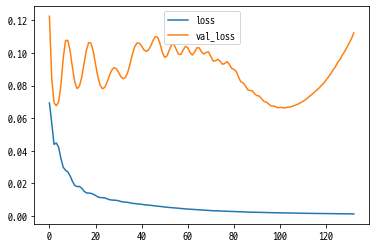

load model...
 11%|█         | 106/1000 [00:30<04:13,  3.52it/s]early stop training...



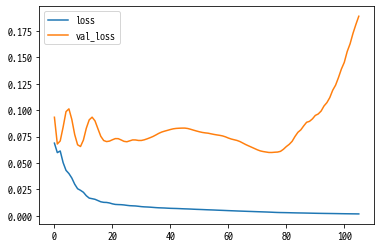

load model...
 14%|█▍        | 140/1000 [00:35<03:39,  3.91it/s]early stop training...



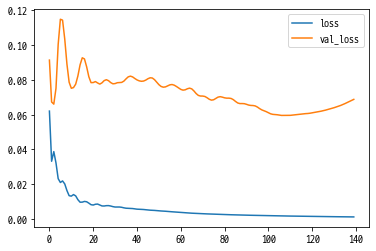

load model...
 12%|█▏        | 122/1000 [00:34<04:06,  3.57it/s]early stop training...



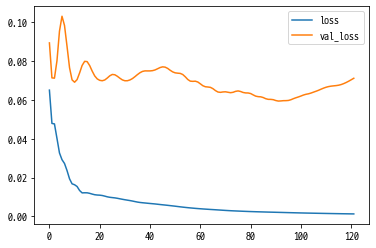

load model...


In [23]:
INPUT_WIDTH = 12
LABEL_WIDTH = 9
LAYER_SIZE = 128
EPOCHS = 1000
BATCH_SIZE = 256


performance_by_topn = {}

for topn in range(1, 11):
    tf.keras.backend.clear_session()
    print(f'Top N: {topn}')
    keywords_topn = [word for word, _, _ in corr_topn_lag[:topn]]
    data_gen = DataGenerator(raw_data=flu_trends_rm1y_norm,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                            feature_cols=['ILI']+keywords_topn, label_cols='ILI',
                            train_split=0.5, val_split=0.2, test_split=0.3)
    model_dir = f'./models/seq2seq_attn/input_len_{INPUT_WIDTH}/lag/topn_{topn}'
    seq2seq_attention = Seq2Seq(LAYER_SIZE, data_gen, is_attn=True)
    history = seq2seq_attention.train_model(epochs=EPOCHS, batch_size=BATCH_SIZE, save_dir=model_dir,
                                            patience=30, plot_history=True)
    seq2seq_attention.restore(model_dir)
    performance_by_topn[topn] = seq2seq_attention.evaluate([RMSE, MAE, CORR])

In [24]:
performance_by_topn

{1: array([[0.17159587, 0.15299331, 0.67846463],
        [0.17924675, 0.16040599, 0.6755049 ],
        [0.18830947, 0.16851969, 0.63756066],
        [0.19505872, 0.17344576, 0.60616174],
        [0.20007073, 0.17658853, 0.58325727],
        [0.20492383, 0.17911834, 0.55922142],
        [0.2110165 , 0.18314376, 0.52250477],
        [0.21889484, 0.18863018, 0.46761563],
        [0.22842442, 0.19561862, 0.39584782]]),
 2: array([[0.27364672, 0.15321715, 0.72126516],
        [0.80980278, 0.4032857 , 0.3747031 ],
        [1.45165005, 0.70722526, 0.23769681],
        [1.50816914, 0.7755588 , 0.25089838],
        [1.14537939, 0.64794278, 0.35546976],
        [0.94941316, 0.57457011, 0.43744943],
        [0.98766035, 0.59160445, 0.44912493],
        [0.99603908, 0.60043847, 0.47290942],
        [0.85435027, 0.54665009, 0.5090136 ]]),
 3: array([[0.16233441, 0.09637943, 0.82270334],
        [0.35144066, 0.20068993, 0.62519152],
        [0.56457004, 0.31999411, 0.47654849],
        [0.74492595, 

Top N: 1
load model...


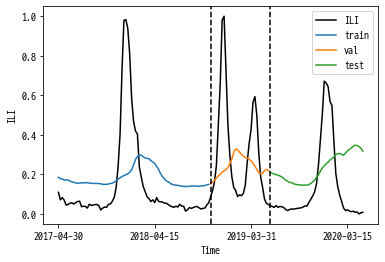

Top N: 2
load model...


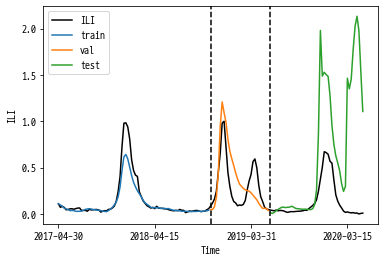

Top N: 3
load model...


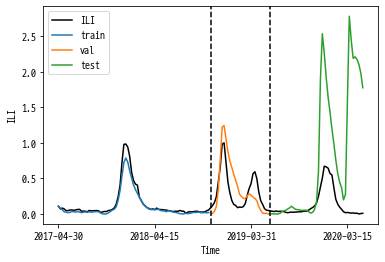

Top N: 4
load model...


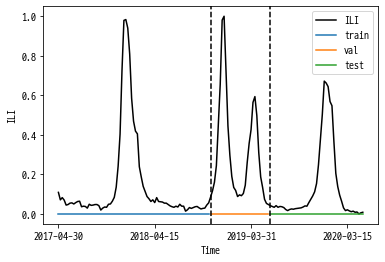

Top N: 5
load model...


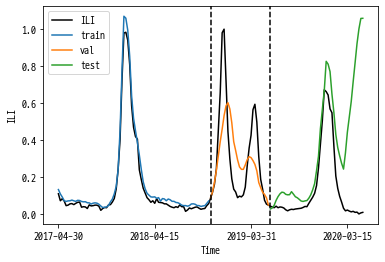

Top N: 6
load model...


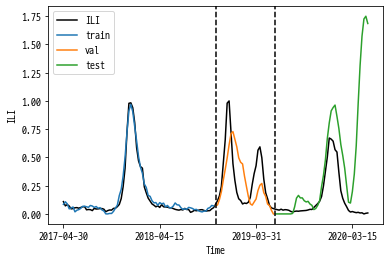

Top N: 7
load model...


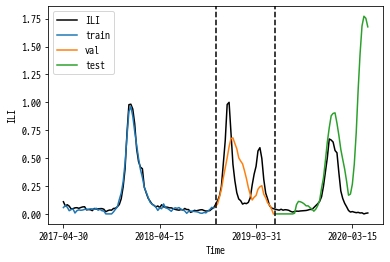

Top N: 8
load model...


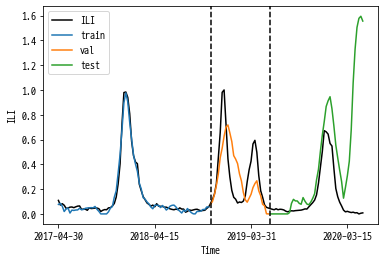

Top N: 9
load model...


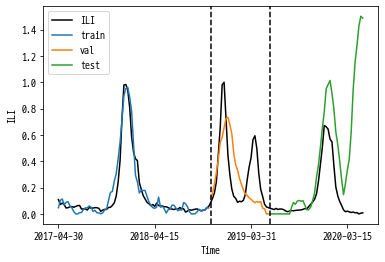

Top N: 10
load model...


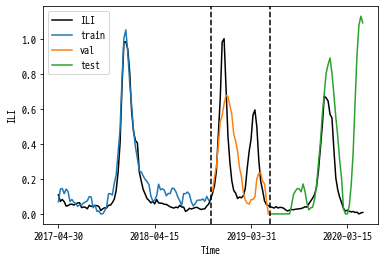

In [19]:
for topn in range(1, 11):
    tf.keras.backend.clear_session()
    print(f'Top N: {topn}')
    keywords_topn = [word for word, _ in corr_topn[:topn]]
    data_gen = DataGenerator(raw_data=flu_trends_rm1y_norm,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                            feature_cols=['ILI']+keywords_topn, label_cols='ILI',
                            train_split=0.5, val_split=0.2, test_split=0.3)
    model_dir = f'./models/seq2seq_attn/input_len_{INPUT_WIDTH}/no_lag/topn_{topn}'
    seq2seq_attention = Seq2Seq(LAYER_SIZE, data_gen, is_attn=True)
    seq2seq_attention.restore(model_dir)
    seq2seq_attention.plot_by_step(5)

In [18]:
performance_by_topn

{1: array([[ 0.16519313,  0.11925035,  0.5926537 ],
        [ 0.17358538,  0.14516815,  0.5276988 ],
        [ 0.19016464,  0.16424413,  0.40789397],
        [ 0.2036271 ,  0.17783881,  0.29811519],
        [ 0.21384943,  0.18802634,  0.20657756],
        [ 0.22202673,  0.19635001,  0.12845362],
        [ 0.22917533,  0.20331701,  0.05405949],
        [ 0.23582384,  0.20973025, -0.02347838],
        [ 0.24221196,  0.21587904, -0.10551752]]),
 2: array([[0.30552202, 0.16134877, 0.50384637],
        [0.88239562, 0.45727591, 0.26954414],
        [1.25808666, 0.64811662, 0.20963169],
        [1.07734206, 0.60967678, 0.32826139],
        [0.9379642 , 0.55361079, 0.39399532],
        [0.81675018, 0.50492958, 0.41157226],
        [0.68651849, 0.43897514, 0.4246711 ],
        [0.61345701, 0.3990589 , 0.42273361],
        [0.54803267, 0.36284927, 0.41137327]]),
 3: array([[0.31751502, 0.17345351, 0.71028482],
        [0.79992704, 0.42278735, 0.45341578],
        [1.12787439, 0.61407519, 0.36303

Input width: 8
load model...


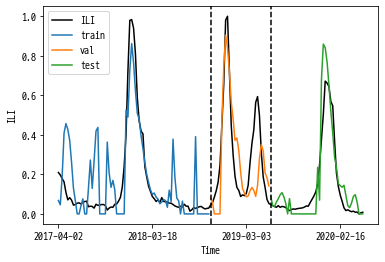

Input width: 12
load model...


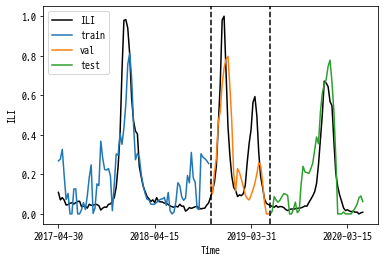

Input width: 16
load model...


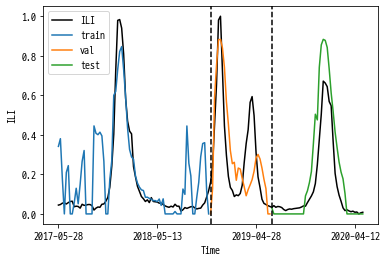

Input width: 20
load model...


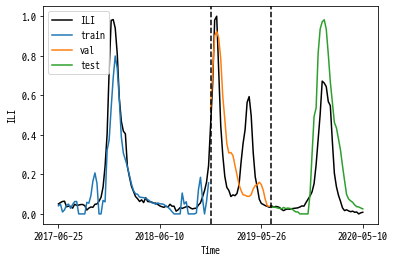

Input width: 24
load model...


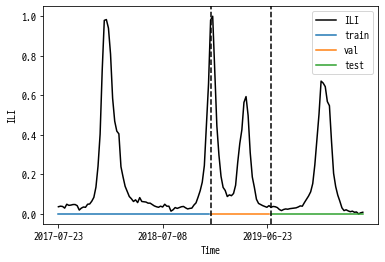

Input width: 28
load model...


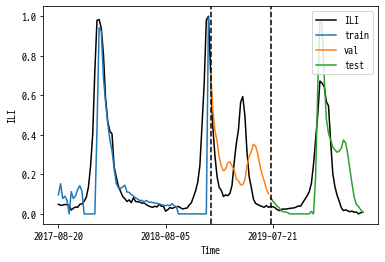

In [44]:
for input_width in [8, 12, 16, 20, 24, 28]:
    tf.keras.backend.clear_session()
    print(f'Input width: {input_width}')
    data_gen = DataGenerator(raw_data=flu_trends_rm1y_norm,
                            input_width=input_width, label_width=LABEL_WIDTH,
                            feature_cols=['ILI'], label_cols='ILI',
                            train_split=0.5, val_split=0.2, test_split=0.3)
    model_dir = f'./models/seq2seq_attn/input_len_{input_width}'
    seq2seq_attention = Seq2Seq(LAYER_SIZE, data_gen, is_attn=True)
    seq2seq_attention.restore(model_dir)
    seq2seq_attention.plot_by_step(5)

In [20]:
performance_by_input_width

{8: array([[0.04397714, 0.02483257, 0.97860395],
        [0.05495852, 0.03283828, 0.96303016],
        [0.06151924, 0.04352188, 0.95030595],
        [0.06642595, 0.05204975, 0.94398415],
        [0.07917526, 0.05748195, 0.93235557],
        [0.09267578, 0.06321659, 0.92342784],
        [0.09721819, 0.06539291, 0.91509362],
        [0.10068472, 0.06943265, 0.89428004],
        [0.12514292, 0.07859992, 0.81969263]]),
 12: array([[0.03382617, 0.02196693, 0.98468921],
        [0.05353046, 0.03489371, 0.96059762],
        [0.07031936, 0.0461684 , 0.93306155],
        [0.07613755, 0.05729946, 0.93028472],
        [0.08370224, 0.06464949, 0.93539526],
        [0.10206784, 0.0793692 , 0.9332228 ],
        [0.13214303, 0.09894046, 0.91697366],
        [0.16768212, 0.12156003, 0.89089777],
        [0.20341953, 0.14407372, 0.85949739]]),
 16: array([[0.03758786, 0.02386183, 0.98418026],
        [0.05511913, 0.0340705 , 0.97811181],
        [0.0742347 , 0.04966256, 0.97662606],
        [0.09509404

Epoch 0: Train Loss 0.0041, Val Loss 0.0576
Epoch 1: Train Loss 0.0045, Val Loss 0.0534
Epoch 2: Train Loss 0.0050, Val Loss 0.0510
Epoch 3: Train Loss 0.0040, Val Loss 0.0574
Epoch 4: Train Loss 0.0044, Val Loss 0.0391
Epoch 5: Train Loss 0.0042, Val Loss 0.0374
Epoch 6: Train Loss 0.0040, Val Loss 0.0566
Epoch 7: Train Loss 0.0042, Val Loss 0.0512
Epoch 8: Train Loss 0.0038, Val Loss 0.0409
Epoch 9: Train Loss 0.0041, Val Loss 0.0407
Epoch 10: Train Loss 0.0037, Val Loss 0.0558
Epoch 11: Train Loss 0.0040, Val Loss 0.0485
Epoch 12: Train Loss 0.0036, Val Loss 0.0398
Epoch 13: Train Loss 0.0039, Val Loss 0.0425
Epoch 14: Train Loss 0.0036, Val Loss 0.0549
Epoch 15: Train Loss 0.0038, Val Loss 0.0471
Epoch 16: Train Loss 0.0035, Val Loss 0.0393
Epoch 17: Train Loss 0.0037, Val Loss 0.0445
Epoch 18: Train Loss 0.0034, Val Loss 0.0544
Epoch 19: Train Loss 0.0036, Val Loss 0.0460
Epoch 20: Train Loss 0.0034, Val Loss 0.0409
Epoch 21: Train Loss 0.0035, Val Loss 0.0500
Epoch 22: Train Loss

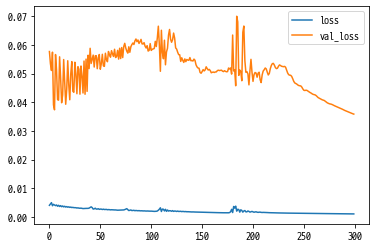

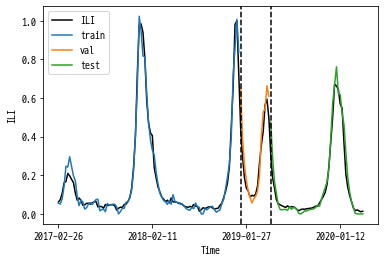

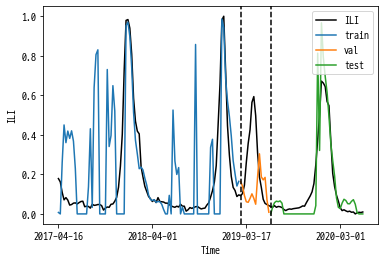

In [100]:
history = seq2seq_no_attention.train_model(epochs=300, batch_size=256, save_dir='./models/seq2seq_no_attn', patience=30, plot_history=True)
seq2seq_no_attention.restore('./models/seq2seq_no_attn')
seq2seq_no_attention.plot_by_step(0)
seq2seq_no_attention.plot_by_step(7)